# 二値分類器への回避攻撃

１．任意のサンプルを選択し、学習モデルに予測確率を出力させる。<br>
２．モデルを分析し、誤分類を起こさせたい方向に重み付けされた特徴を探す。<br>
　　（分類器の自信を減らすような特徴を見つける）<br>
３．予測確率がしきい値（通常0.5）を超えるまで、特徴の大きさを繰り返し調節する。

## クロスサイトスクリプティング(XSS)の分類を行う事前学習済みモデルに攻撃
このモデルはWebアプリケーションファイアウォール(WAF)として機能している。<br>
具体的な機能：　文字列を指定するとXSSのインスタンスかどうかを判定する。

仮定：　完璧な攻撃者はモデル脆弱性の最悪なケース評価を実行し、この攻撃の上限を示すことができると仮定する。<br>
（今回の場合、攻撃者はScikit-learn Pipelineオブジェクトにアクセスでき、モデルのパイプラインの各段階を検査できると仮定する。）

### 事前学習済みモデルをロードする

In [21]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

p = pickle.load(open('waf/trained_waf_model', 'rb'))

/home/takusub/.pyenv/versions/anaconda3-5.1.0/envs/TensorFlow/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/takusub/.pyenv/versions/anaconda3-5.1.0/envs/TensorFlow/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/takusub/.pyenv/versions/anaconda3-5.1.0/envs/TensorFlow/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/takusub/.pyenv/versions/anaconda3-5.1.0/envs/TensorFlow/lib/python3.6/si

### 学習モデルの構成を示す

In [22]:
vars(p)

{'memory': None,
 'steps': [('vectorizer',
   TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
           ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=True,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('classifier', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
             fit_intercept=True, intercept_scaling=1, max_iter=100,
             multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
             solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]}

パイプラインオブジェクト（学習モデルの中身）をみることができる<br>
'vectorizer'=TfidfVectorizer  　　: 文書をベクトル化、各特徴量がどの程度情報を持っているのかを測る<br>
'classifier'=LogisticRegression　: XSSの文書かどうかを分類する<br>
<img src="figures/ModelPipeline.png">

## ベクタライザの中身を見る

#### ベクタライザ(tf-idf)の各用語の重みを見る
$$tfidf(w,d)=tf \log{\frac{N+1}{N_w+1}}$$
tf: 単語の出現頻度<br>
N : 訓練データ中の文書の数<br>
Nw: 訓練データ中でwが現れる文書の数

In [23]:
vec = p.steps[0][1]
print(vec.idf_)

[ 9.88191796 13.29416517 13.98731235 ... 14.39277746 14.39277746
 14.39277746]


#### 分類器(ロジスティック回帰）の重み係数を見る

In [24]:
clf = p.steps[1][1]
print(clf.coef_)

[[3.86345441e+00 2.97867212e-02 1.67598454e-03 ... 5.48339628e-06
  5.48339628e-06 5.48339628e-06]]


#### 辞書の中身を見てみる

In [25]:
vec.vocabulary_

{'/': 10522,
 'j': 59431,
 'a': 38945,
 'v': 86105,
 's': 79024,
 'c': 43527,
 'r': 76641,
 'i': 57223,
 'p': 72543,
 't': 81489,
 'm': 65680,
 'o': 70279,
 'n': 67925,
 'e': 48183,
 'y': 92321,
 '.': 9860,
 'x': 90144,
 '\n': 154,
 '/j': 11969,
 'ja': 60022,
 'av': 41076,
 'va': 86839,
 'as': 40902,
 'sc': 80190,
 'cr': 45330,
 'ri': 78053,
 'ip': 58842,
 'pt': 74414,
 't/': 81891,
 '/m': 12101,
 'mo': 67318,
 'on': 71801,
 'ne': 69117,
 'ey': 50667,
 'y.': 92541,
 '.e': 10250,
 'ex': 50609,
 'xe': 91218,
 'e\n': 48184,
 '/ja': 11985,
 'jav': 60068,
 'ava': 41103,
 'vas': 86886,
 'asc': 40942,
 'scr': 80235,
 'cri': 45365,
 'rip': 78100,
 'ipt': 58892,
 'pt/': 74433,
 't/m': 81931,
 '/mo': 12138,
 'mon': 67355,
 'one': 71847,
 'ney': 69175,
 'ey.': 50678,
 'y.e': 92549,
 '.ex': 10263,
 'exe': 50644,
 'xe\n': 91219,
 '&': 4002,
 'h': 55125,
 ' ': 348,
 'u': 84107,
 'z': 94408,
 'l': 63324,
 '$': 3487,
 '(': 5071,
 '4': 21211,
 '+': 7199,
 '9': 30764,
 ')': 5690,
 "'": 4414,
 '&&': 4050

#### 特徴の組み合わせ
おのおの組み合わせた特徴の重みを見る

In [26]:
term_influence = vec.idf_ * clf.coef_
print(term_influence)

[[3.81783395e+01 3.95989592e-01 2.34425193e-02 ... 7.89213024e-05
  7.89213024e-05 7.89213024e-05]]


## 特徴の重み（影響度）が高いインデックス順にランキング

In [27]:
print(np.argpartition(term_influence, 1))

[[81937 92199     2 ... 97829 97830 97831]]


インデックス＝81937が最も影響力が強い！

In [28]:
# First, we create a token vocabulary dictionary so that
# we can access tokens by index.
vocab = dict([(v,k) for k,v in vec.vocabulary_.items()])
print(vocab[81937])

t/s


In [29]:
payload = "<script>alert(1)</script>"
p.predict([payload])[0]

1

0 : 正常な文字列<br>
1 : XSSの文字列（異常）

In [30]:
p.predict_proba([payload])[0]

array([1.86163618e-09, 9.99999998e-01])

In [31]:
p.predict_proba([payload + '/' + vocab[81937]])[0]

array([1.83734699e-07, 9.99999816e-01])

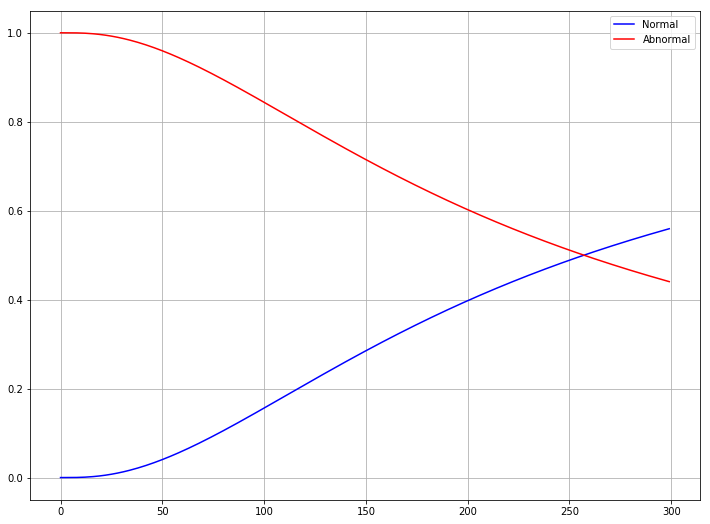

In [47]:
x, y = [], []
for i in range(300):
    x.append(i)
    a = p.predict_proba([payload + '/' + vocab[81937] * i])[0]
    y.append(a)

x = np.array(x)
y = np.array(y)
plt.figure(figsize=(12, 9))
plt.plot(x, y[:,0], 'b-', label='Normal')
plt.plot(x, y[:, 1], 'r-', label='Abnormal')
plt.legend()
plt.grid()

In [48]:
p.predict_proba([payload + '/' + vocab[81937]*260])[0]

array([0.50452447, 0.49547553])

In [50]:
print(payload + '/' + vocab[81937]*260)

<script>alert(1)</script>/t/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/st/s


In [51]:
p.predict([payload + '/' + vocab[81937]*260])[0]

0